In [47]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
from statsmodels.formula.api import ols
from sklearn.metrics import classification_report, plot_confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [2]:
#import data into pandas dataframe
file = "../data/ultimate_data_challenge.json"
df = pd.read_json(file)

In [3]:
df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [4]:
df.tail()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
49995,King's Landing,0,2014-01-25,5.0,1.0,2014-06-05,iPhone,0.0,False,100.0,5.63,4.2
49996,Astapor,1,2014-01-24,NaN,1.0,2014-01-25,iPhone,0.0,False,0.0,0.00,4.0
49997,Winterfell,0,2014-01-31,5.0,1.0,2014-05-22,Android,0.0,True,100.0,3.86,5.0
49998,Astapor,2,2014-01-14,3.0,1.0,2014-01-15,iPhone,0.0,False,100.0,4.58,3.5
49999,Astapor,0,2014-01-18,NaN,1.0,2014-04-20,Android,0.0,False,0.0,3.49,5.0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [6]:
#convert signup date and 
df['signup_date'] = df['signup_date'].astype('datetime64[ns]')
df['last_trip_date'] = df['last_trip_date'].astype('datetime64[ns]')

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   city                    50000 non-null  object        
 1   trips_in_first_30_days  50000 non-null  int64         
 2   signup_date             50000 non-null  datetime64[ns]
 3   avg_rating_of_driver    41878 non-null  float64       
 4   avg_surge               50000 non-null  float64       
 5   last_trip_date          50000 non-null  datetime64[ns]
 6   phone                   49604 non-null  object        
 7   surge_pct               50000 non-null  float64       
 8   ultimate_black_user     50000 non-null  bool          
 9   weekday_pct             50000 non-null  float64       
 10  avg_dist                50000 non-null  float64       
 11  avg_rating_by_driver    49799 non-null  float64       
dtypes: bool(1), datetime64[ns](2), float64(6), int

In [8]:
df.city.unique()

array(["King's Landing", 'Astapor', 'Winterfell'], dtype=object)

In [9]:
df.phone.unique()

array(['iPhone', 'Android', None], dtype=object)

In [10]:
#Fill null values in phone column with 'Other'
df['phone'] = df.phone.fillna(value='Other')

In [11]:
avg_rat_of = round(df.avg_rating_of_driver.mean(),1)
avg_rat_by = round(df.avg_rating_by_driver.mean(),1)

In [12]:
#Fill null values with column average
df['avg_rating_of_driver'] = df.avg_rating_of_driver.fillna(value=avg_rat_of)
df['avg_rating_by_driver'] = df.avg_rating_by_driver.fillna(value=avg_rat_by)

In [13]:
df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [14]:
#create target variable of 
df['sixth_month_active']=(df.last_trip_date - df.signup_date) > timedelta(days=365*5/12)
df['sixth_month_active'] = df.sixth_month_active.astype(int)

In [15]:
df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,sixth_month_active
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0,0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0,0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0,0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9,1
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9,0


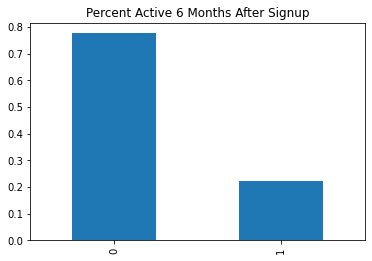

In [16]:
df['sixth_month_active'].value_counts(normalize=True).plot(kind='bar', title='Percent Active 6 Months After Signup')

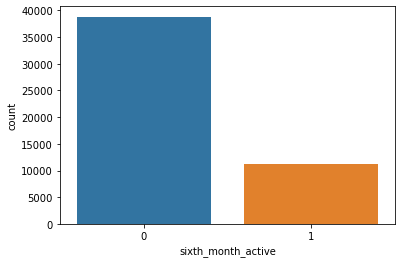

In [17]:
sns.countplot(x="sixth_month_active", data=df)

     phone  sixth_month_active  count
0  Android                   0  13273
1  Android                   1   1749
2    Other                   0    319
3    Other                   1     77
4   iPhone                   0  25214
5   iPhone                   1   9368


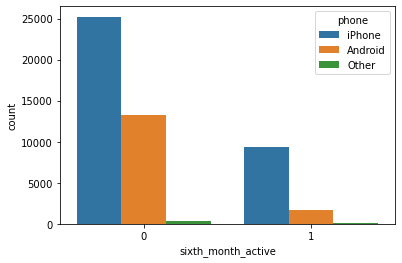

In [18]:
print(df.groupby(['phone','sixth_month_active'])['signup_date'].count().reset_index(name="count"))
sns.countplot(x="sixth_month_active", data=df, hue='phone')

   ultimate_black_user  sixth_month_active  count
0                False                   0  25732
1                False                   1   5414
2                 True                   0  13074
3                 True                   1   5780


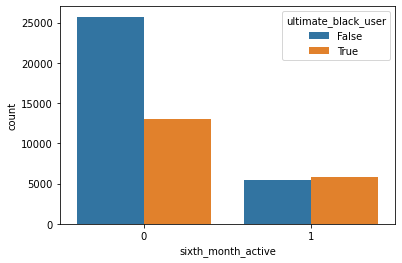

In [19]:
print(df.groupby(['ultimate_black_user','sixth_month_active']).size().reset_index(name='count'))
sns.countplot(x="sixth_month_active", data=df, hue='ultimate_black_user')

             city  sixth_month_active  count
0         Astapor                   0  14065
1         Astapor                   1   2469
2  King's Landing                   0   6471
3  King's Landing                   1   3659
4      Winterfell                   0  18270
5      Winterfell                   1   5066


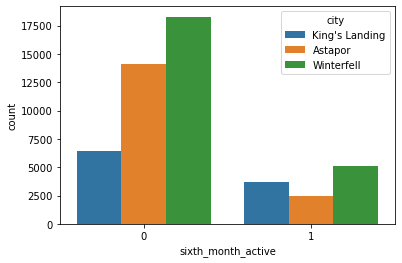

In [20]:
print(df.groupby(['city','sixth_month_active']).size().reset_index(name='count'))
sns.countplot(x="sixth_month_active", data=df, hue='city')

### Statistical Analysis - Discrete Variables

In [21]:
#chi-square test for phone
chi_phone = pd.crosstab(df.sixth_month_active, df.phone)
chi2, p_value, dof, ex = chi2_contingency(chi_phone)
print(f"chi2: {chi2:.3f} \np-value: {p_value: .3f} \nDOF: {dof} \nExpected: {ex}")

chi2: 1440.016 
p-value:  0.000 
DOF: 2 
Expected: [[11658.87464   307.34352 26839.78184]
 [ 3363.12536    88.65648  7742.21816]]


In [22]:
#chi-square test for ultimate black users
chi_ultimate = pd.crosstab(df.sixth_month_active, df.ultimate_black_user)
chi2, p_value, dof, ex = chi2_contingency(chi_ultimate)
print(f"chi2: {chi2:.3f} \np-value: {p_value: .3f} \nDOF: {dof} \nExpected: {ex}")

chi2: 1190.186 
p-value:  0.000 
DOF: 1 
Expected: [[24173.03352 14632.96648]
 [ 6972.96648  4221.03352]]


In [23]:
#chi-square test for city
chi_city = pd.crosstab(df.sixth_month_active, df.city)
chi2, p_value, dof, ex = chi2_contingency(chi_city)
print(f"chi2: {chi2:.3f} \np-value: {p_value: .3f} \nDOF: {dof} \nExpected: {ex}")

chi2: 1634.469 
p-value:  0.000 
DOF: 2 
Expected: [[12832.36808  7862.0956  18111.53632]
 [ 3701.63192  2267.9044   5224.46368]]


### Statistical Analysis - Discrete Variables

In [24]:
continuous_df = df.drop(['city','signup_date','last_trip_date','phone','ultimate_black_user'], axis=1)

In [25]:
features = continuous_df.drop('sixth_month_active',axis=1).columns

In [26]:
#ANOVA test for continuous variables
for feature in features:
    model = ols('sixth_month_active ~ '+feature, continuous_df).fit()
    print(feature + f" p = {model.f_pvalue: .4f}")

trips_in_first_30_days p =  0.0000
avg_rating_of_driver p =  0.1036
avg_surge p =  0.1051
surge_pct p =  0.0000
weekday_pct p =  0.7531
avg_dist p =  0.0000
avg_rating_by_driver p =  0.0000


In [27]:
#create dataframe with statistically significant variables and target variable
model_df = df.drop(['signup_date','last_trip_date','avg_rating_of_driver','avg_surge','weekday_pct'],axis=1)

In [29]:
model_df

,city,trips_in_first_30_days,phone,surge_pct,ultimate_black_user,avg_dist,avg_rating_by_driver,sixth_month_active
0,King's Landing,4,iPhone,15.4,True,3.67,5.0,0
1,Astapor,0,Android,0.0,False,8.26,5.0,0
2,Astapor,3,iPhone,0.0,False,0.77,5.0,0
3,King's Landing,9,iPhone,20.0,True,2.36,4.9,1
4,Winterfell,14,Android,11.8,False,3.13,4.9,0
...,...,...,...,...,...,...,...,...
49995,King's Landing,0,iPhone,0.0,False,5.63,4.2,0
49996,Astapor,1,iPhone,0.0,False,0.00,4.0,0
49997,Winterfell,0,Android,0.0,True,3.86,5.0,0
49998,Astapor,2,iPhone,0.0,False,4.58,3.5,0


### Machine Learning

<statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x1190bbc40> Best params: {'knn__n_neighbors': 30, 'knn__weights': 'uniform'}
              precision    recall  f1-score   support

           0       0.82      0.94      0.88      7784
           1       0.57      0.28      0.38      2216

    accuracy                           0.79     10000
   macro avg       0.69      0.61      0.63     10000
weighted avg       0.77      0.79      0.77     10000



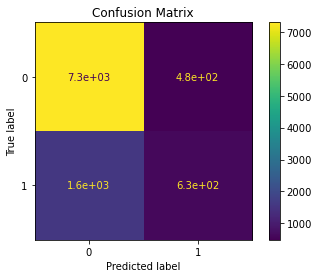

In [58]:
#create transformer for continuous variables
numeric_features = ['trips_in_first_30_days', 'surge_pct','avg_dist','avg_rating_by_driver']
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

#create transformer for discrete variables
categorical_features = ['city', 'city', 'ultimate_black_user']
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder())])

#create preprocessor pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# ass classifier to preprocessing pipeline.
steps=[('preprocessor', preprocessor),('knn', KNeighborsClassifier())]

#create pipeline
pipeline = Pipeline(steps)

parameters = {'knn__n_neighbors':[5,10,15,20,25,30], 'knn__weights': ['uniform','distance']}

cv = GridSearchCV(pipeline, param_grid=parameters, cv=3)

X = model_df.drop('sixth_month_active', axis=1)
y = df['sixth_month_active']

#split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

#train model
cv.fit(X_train, y_train)
#test model
y_pred = cv.predict(X_test)
    
#print score and confusion matrix
print(str(model)+" Best params:", cv.best_params_)
print(classification_report(y_test, y_pred, zero_division=0))
plot_confusion_matrix(cv, X_test, y_test)
plt.title("Confusion Matrix")
plt.show()